In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [5]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

## Sampling

In [7]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

## Encoder

We can not use the RELU for the mean and standard deviation because the standard variation would give us a value ranging from 0-1 and when these values are too close to zero, with the relu, it would cause instability in our model. But log would handle this because if the log of 1 is 0, we can get the log of the variance which would then let the values range from -inf to 0 and this would be a much more larger set of possible vals than 0&1

In [8]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

## Decoder

In [9]:
latent_inputs = Input(shape=(LATENT_DIM,))


x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

## Overall VAE Model

In [10]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
for i in range(3):
  print(vae.layers[i])

## Training

In [12]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20

In [13]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [14]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

In [15]:

def method(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [16]:
method(EPOCHS)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(187.36505, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(167.95207, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(157.28506, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(144.93158, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(151.95724, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(150.74013, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(151.04521, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(155.51262, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(150.0594, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(154.07944, shape=(), dtype=float32)


## Overriding train_step Method

In [17]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [18]:
model=VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=20,batch_size=128,)

Epoch 1/20
547/547 [==============================] - 6s 8ms/step - loss: 149.9137
Epoch 2/20
547/547 [==============================] - 6s 10ms/step - loss: 149.6419
Epoch 3/20
547/547 [==============================] - 4s 8ms/step - loss: 149.5596
Epoch 4/20
547/547 [==============================] - 4s 8ms/step - loss: 149.5389
Epoch 5/20
547/547 [==============================] - 4s 8ms/step - loss: 149.2089
Epoch 6/20
547/547 [==============================] - 4s 8ms/step - loss: 149.1497
Epoch 7/20
547/547 [==============================] - 5s 8ms/step - loss: 149.0153
Epoch 8/20
547/547 [==============================] - 4s 8ms/step - loss: 148.9225
Epoch 9/20
547/547 [==============================] - 4s 8ms/step - loss: 148.7134
Epoch 10/20
547/547 [==============================] - 5s 9ms/step - loss: 148.6814
Epoch 11/20
547/547 [==============================] - 4s 8ms/step - loss: 148.5519
Epoch 12/20
547/547 [==============================] - 4s 8ms/step - loss: 148.4030


# Testing

In [19]:
scale=1
n=16

In [20]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [21]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 19ms/step


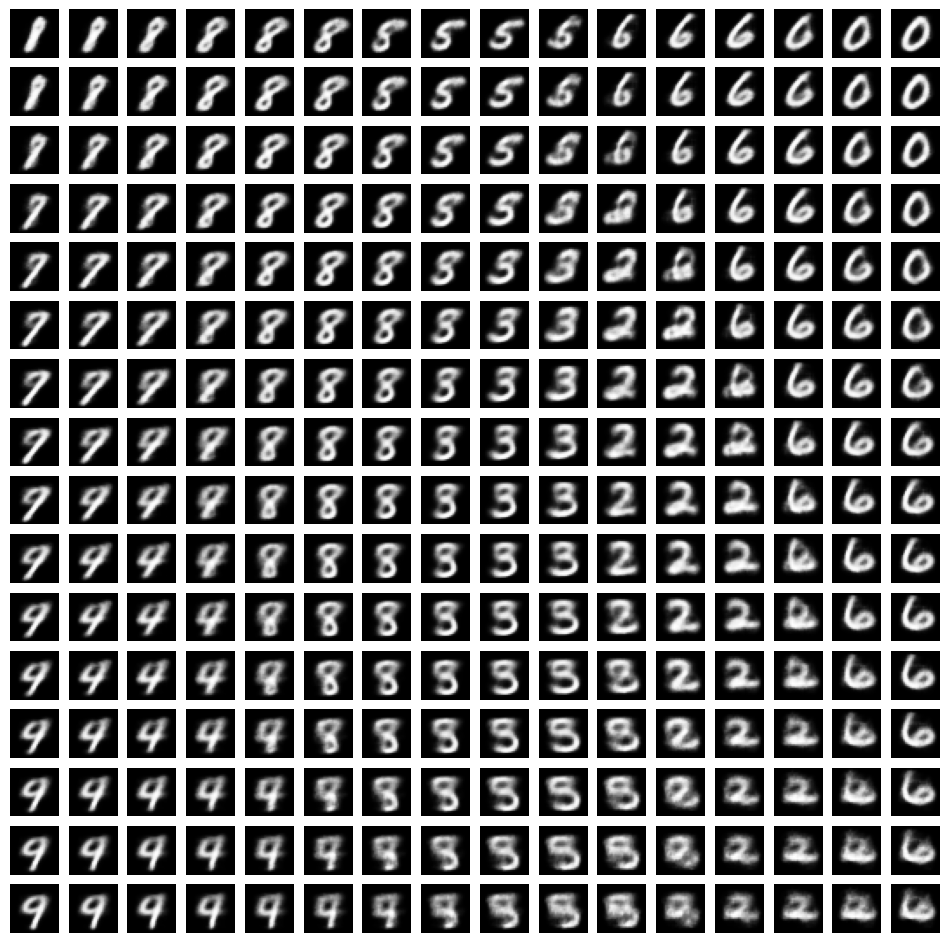

In [22]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=model.decoder.predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1

In [23]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 [==============================] - 0s 94ms/step
(28, 28)


In [24]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 [==============================] - 3s 2ms/step


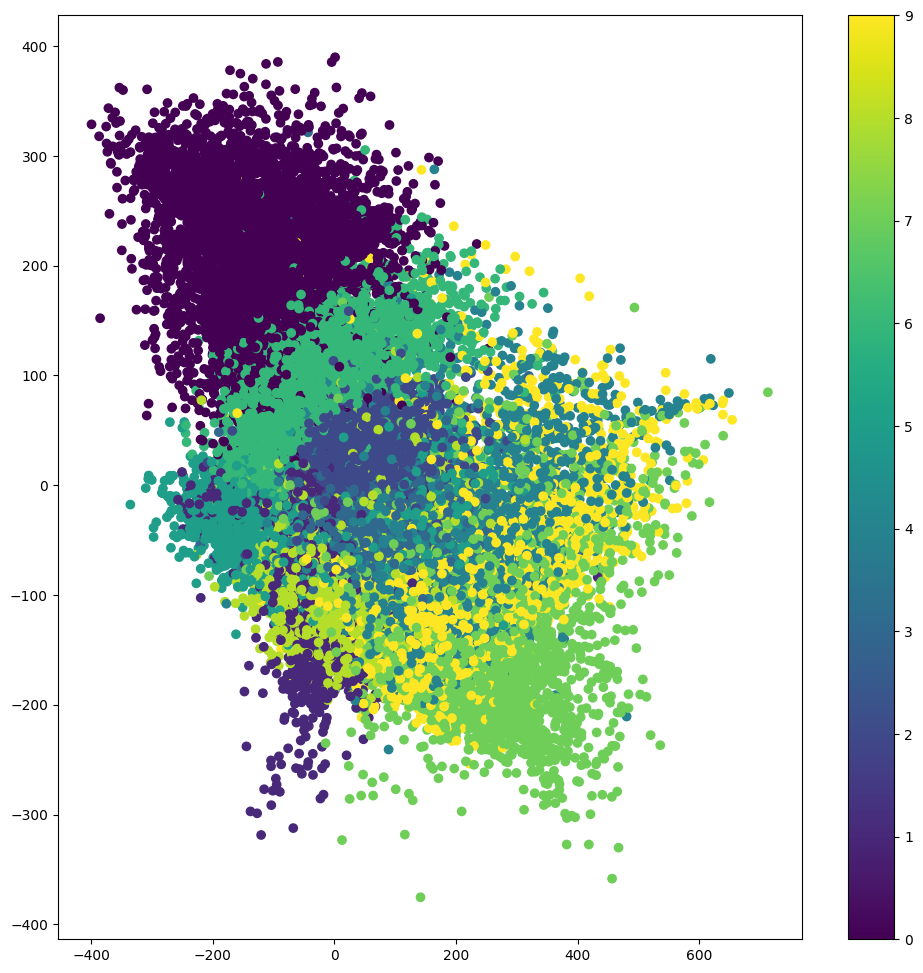

In [25]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()